# Trabalho prático DAA

### Acidentes Rodoviários

Este dataset contém 5000 casos e 13 features :

- city_name
- magnitude_of_delay
- delay_in_seconds
- affected_roads
- record_date
- luminosity
- avg_temperature
- avg_atm_pressure
- avg_humidity
- avg_wind_speed
- avg_precipitation
- avg_rain
- incidents

Corresponde a um problema de classificação multípla, sendo o atributo target (a prever),
incidents (nível de gravidade de um acidente).
As classficações deste atributo podem ser:

- Very High
- High
- Medium
- Low
- Node


Existe também um dataset de teste, com 1206 casos.

## Importar Bibliotecas

In [156]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Get the data

In [157]:
data = pd.read_csv('sbstpdaa2223/training_data.csv')
test = pd.read_csv('sbstpdaa2223/test_data.csv')

## Exploração superficial dos datasets

Vista básica do dataset inicial, para treino.

In [158]:
data.shape

(5000, 13)

Vista básica do dataset inicial, para teste.

In [159]:
test.shape

(1206, 12)

In [160]:
data.head()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


In [161]:
data.nunique()

city_name                1
magnitude_of_delay       3
delay_in_seconds      1186
affected_roads         678
record_date           5000
luminosity               3
avg_temperature         35
avg_atm_pressure        36
avg_humidity            83
avg_wind_speed          11
avg_precipitation        1
avg_rain                 4
incidents                5
dtype: int64

## Missing Values

- É visível que o único atributo que tem valores "perdidos" ou null é o affected_roads(85 linhas - treino, 22- teste).

<AxesSubplot:>

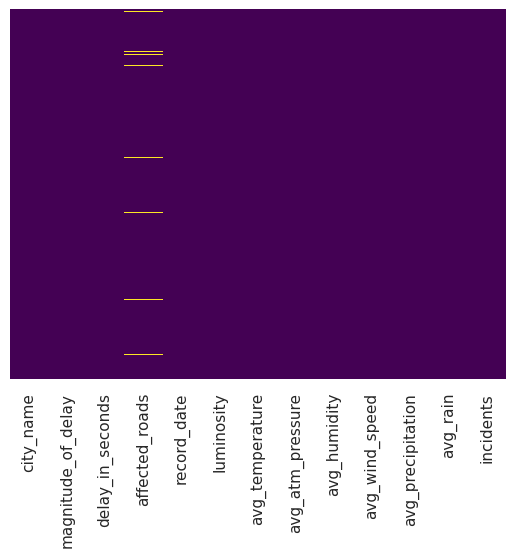

In [162]:
sns.heatmap(data.isnull(),yticklabels=False, cbar=False,cmap='viridis')

In [163]:
data.isna().any()

city_name             False
magnitude_of_delay    False
delay_in_seconds      False
affected_roads         True
record_date           False
luminosity            False
avg_temperature       False
avg_atm_pressure      False
avg_humidity          False
avg_wind_speed        False
avg_precipitation     False
avg_rain              False
incidents             False
dtype: bool

In [164]:
#count the null values in each column
data.isna().sum()

city_name              0
magnitude_of_delay     0
delay_in_seconds       0
affected_roads        85
record_date            0
luminosity             0
avg_temperature        0
avg_atm_pressure       0
avg_humidity           0
avg_wind_speed         0
avg_precipitation      0
avg_rain               0
incidents              0
dtype: int64

In [165]:
test.isna().sum()

city_name              0
magnitude_of_delay     0
delay_in_seconds       0
affected_roads        22
record_date            0
luminosity             0
avg_temperature        0
avg_atm_pressure       0
avg_humidity           0
avg_wind_speed         0
avg_precipitation      0
avg_rain               0
dtype: int64

## Valores duplicados

Os datasets não têm qualquer valor duplicado, pelo que não é necessário tratamento.

In [166]:
print(data.duplicated().sum())
print(data.info())

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB
None


In [167]:
print(test.duplicated().sum())
print(test.info())

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           1206 non-null   object 
 1   magnitude_of_delay  1206 non-null   object 
 2   delay_in_seconds    1206 non-null   int64  
 3   affected_roads      1184 non-null   object 
 4   record_date         1206 non-null   object 
 5   luminosity          1206 non-null   object 
 6   avg_temperature     1206 non-null   float64
 7   avg_atm_pressure    1206 non-null   float64
 8   avg_humidity        1206 non-null   float64
 9   avg_wind_speed      1206 non-null   float64
 10  avg_precipitation   1206 non-null   float64
 11  avg_rain            1206 non-null   object 
dtypes: float64(5), int64(1), object(6)
memory usage: 113.2+ KB
None


## Análise Exploratória

Esta vai ser unicamente realizada com base no dataset de treino, sendo com base neste que o modelo será realizado. (Contudo, preparado para qualquer dataset análogo)

As alterações, com a exceção da remoção de linhas, serão também realizadas no dataset de treino

## Atributos categóricos

### Analisar o target ('incidents')

- Com base nos gráficos a baixo apresentados, é notável que a maioria dos valores encontram-se como none, na classificação do acidente.

- Com a exceção do High, os restantes tem um número de ocorrências semelhantes.

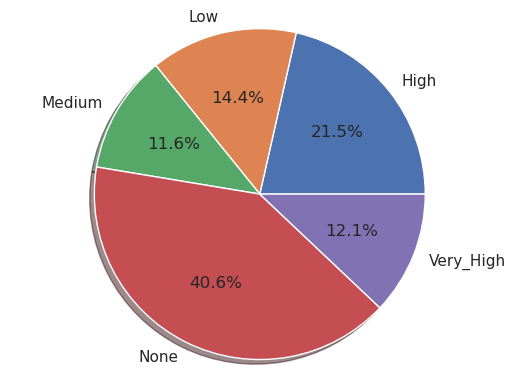

In [168]:
labels = data['incidents'].astype('category').cat.categories.tolist()
counts = data['incidents'].value_counts()

sizes = [counts[var_cat] for var_cat in labels]

fig, axl = plt.subplots()

axl.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the ¥ on plot
axl. axis('equal')

plt.show()

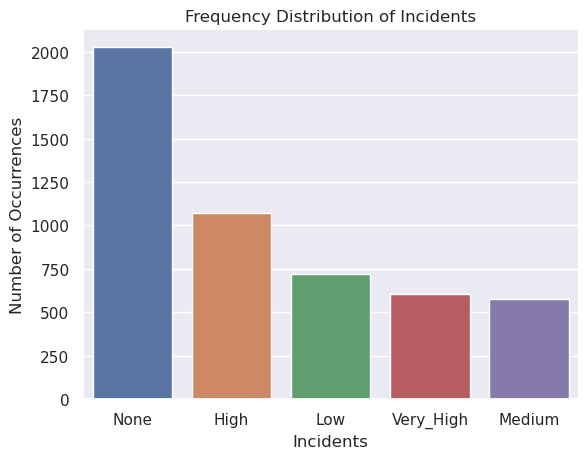

In [169]:
incidents_count = data['incidents'].value_counts()
sns.set(style="darkgrid")

sns.barplot(x=incidents_count.index, y=incidents_count.values)
plt.title('Frequency Distribution of Incidents')

plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Incidents', fontsize=12)

plt.show()

### Atributo 'magnitude_of_delay'

- A categoria 'Moderate' tem apenas 8 casos.
- A maioria das linhas estão no caso 'Undefined'(86.3%).

In [170]:
data['magnitude_of_delay'].value_counts()

UNDEFINED    4314
MAJOR         678
MODERATE        8
Name: magnitude_of_delay, dtype: int64

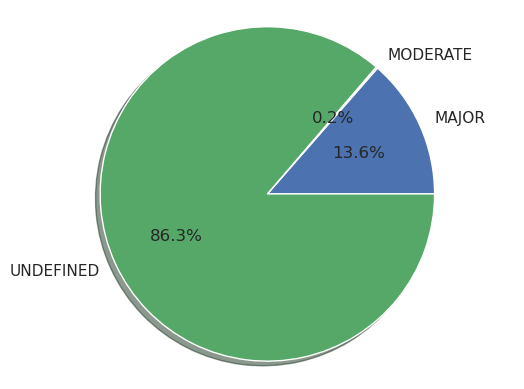

In [171]:
labels = data['magnitude_of_delay'].astype('category').cat.categories.tolist()
counts = data['magnitude_of_delay'].value_counts()

sizes = [counts[var_cat] for var_cat in labels]

fig, axl = plt.subplots()

axl.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the ¥ on plot
axl. axis('equal')

plt.show()

<AxesSubplot:title={'center':'Magnitude e output target'}>

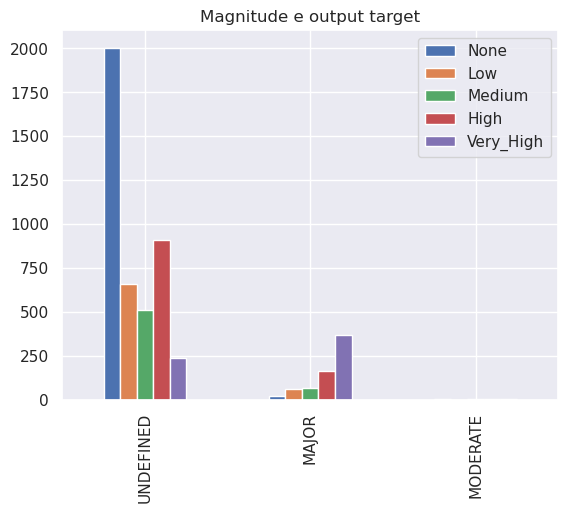

In [172]:
magnitude_target = pd.DataFrame()
magnitude_target['None'] = data[data['incidents'] == 'None']['magnitude_of_delay'].value_counts()
magnitude_target['Low'] = data[data['incidents'] == 'Low']['magnitude_of_delay'].value_counts()
magnitude_target['Medium'] = data[data['incidents'] == 'Medium']['magnitude_of_delay'].value_counts()
magnitude_target['High'] = data[data['incidents'] == 'High']['magnitude_of_delay'].value_counts()
magnitude_target['Very_High'] = data[data['incidents'] == 'Very_High']['magnitude_of_delay'].value_counts()
magnitude_target.plot.bar(title="Magnitude e output target")

### Atributo 'affected_roads'

Neste caso, verifica-se que existe uma quantidade elevado de valores unicos.
Uma vez que existem combinações várias de estradas pelas várias linhas, sendo possível visualizar qu, em alguns casos, só numa linha tem aquela combinação.
Adicionalmente, existe uma repetição excessiva de estradas em cada linha.

In [173]:
data['affected_roads'].value_counts()

N101,N101,N101,N101,N101                                                                                                                                      1514
N101,N101,N101,N101,N101,                                                                                                                                     1078
,                                                                                                                                                              709
N101,N101                                                                                                                                                      149
N101,N101,N101,N101,N101,N101                                                                                                                                  114
                                                                                                                                                              ... 
N101,N101,N105,N105,N1

### Atributo 'record_date'

- Os acidentes, ocorram em datas diferentes (dado a incluir as horas do dia).

In [174]:
data['record_date'].value_counts()

2021-03-15 23:00    1
2021-10-29 07:00    1
2021-04-25 03:00    1
2021-03-17 17:00    1
2021-07-22 00:00    1
                   ..
2021-10-19 00:00    1
2021-10-22 23:00    1
2021-12-04 23:00    1
2021-09-13 23:00    1
2021-12-20 02:00    1
Name: record_date, Length: 5000, dtype: int64

### Atributo 'luminosity'


In [175]:
data['luminosity'].value_counts()

DARK         2489
LIGHT        2325
LOW_LIGHT     186
Name: luminosity, dtype: int64

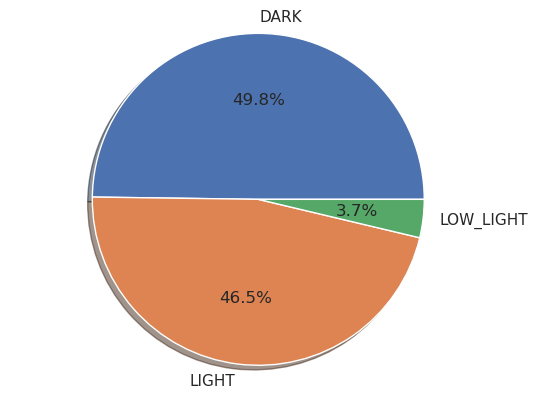

In [176]:
labels = data['luminosity'].astype('category').cat.categories.tolist()
counts = data['luminosity'].value_counts()

sizes = [counts[var_cat] for var_cat in labels]

fig, axl = plt.subplots()

axl.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the ¥ on plot
axl. axis('equal')

plt.show()

<AxesSubplot:title={'center':'Luminosidade e output target'}>

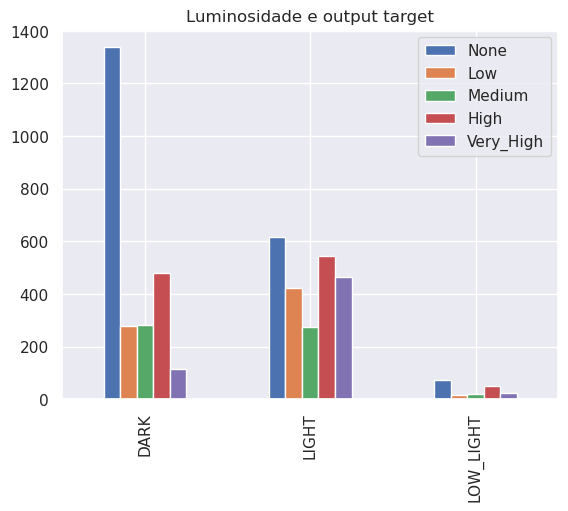

In [177]:
luminosity_target = pd.DataFrame()
luminosity_target['None'] = data[data['incidents'] == 'None']['luminosity'].value_counts()
luminosity_target['Low'] = data[data['incidents'] == 'Low']['luminosity'].value_counts()
luminosity_target['Medium'] = data[data['incidents'] == 'Medium']['luminosity'].value_counts()
luminosity_target['High'] = data[data['incidents'] == 'High']['luminosity'].value_counts()
luminosity_target['Very_High'] = data[data['incidents'] == 'Very_High']['luminosity'].value_counts()
luminosity_target.plot.bar(title="Luminosidade e output target")

### Atributo 'avg_rain'

- É notável que existe uma quantidade mínima de valores na categoria "chuva forte"

In [178]:
data['avg_rain'].value_counts()

Sem Chuva         4756
chuva fraca        214
chuva moderada      27
chuva forte          3
Name: avg_rain, dtype: int64

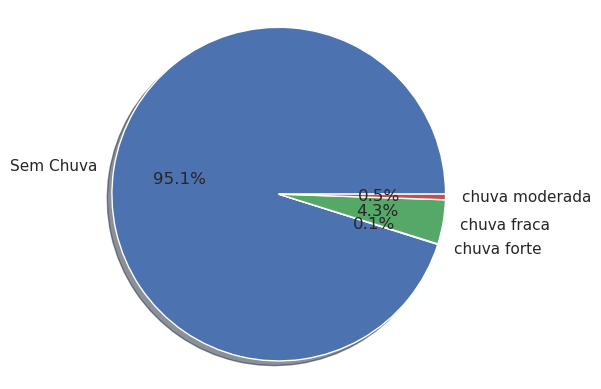

In [179]:
labels = data['avg_rain'].astype('category').cat.categories.tolist()
counts = data['avg_rain'].value_counts()

sizes = [counts[var_cat] for var_cat in labels]

fig, axl = plt.subplots()

axl.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the ¥ on plot
axl. axis('equal')

plt.show()

<AxesSubplot:title={'center':'Média de chuva e output target'}>

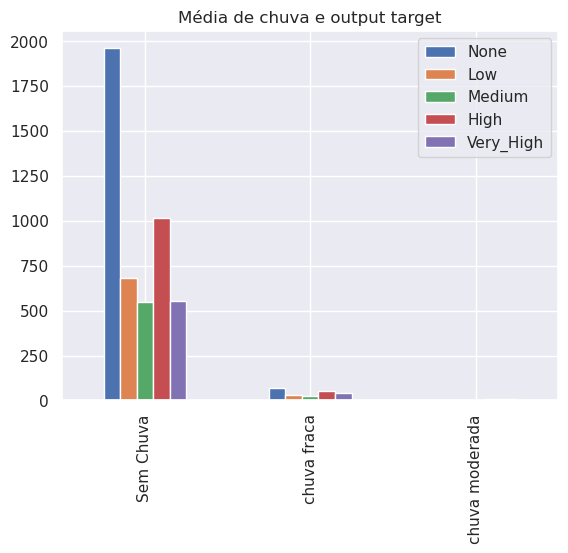

In [180]:
avg_rain_target = pd.DataFrame()
avg_rain_target['None'] = data[data['incidents'] == 'None']['avg_rain'].value_counts()
avg_rain_target['Low'] = data[data['incidents'] == 'Low']['avg_rain'].value_counts()
avg_rain_target['Medium'] = data[data['incidents'] == 'Medium']['avg_rain'].value_counts()
avg_rain_target['High'] = data[data['incidents'] == 'High']['avg_rain'].value_counts()
avg_rain_target['Very_High'] = data[data['incidents'] == 'Very_High']['avg_rain'].value_counts()
avg_rain_target.plot.bar(title="Média de chuva e output target")

### Atributo 'city_name'

- A amostra é numa única cidade (Guimarães).

In [181]:
data['city_name'].value_counts()

Guimaraes    5000
Name: city_name, dtype: int64

## Atributos Numéricos

### Atributo 'delay_in_seconds'

É visível que este atributo está mal distribuído, não só pelo histograma, como pela boxplot.

Com um elevado número de outliers.

Histogram: AxesSubplot(0.125,0.11;0.775x0.77)


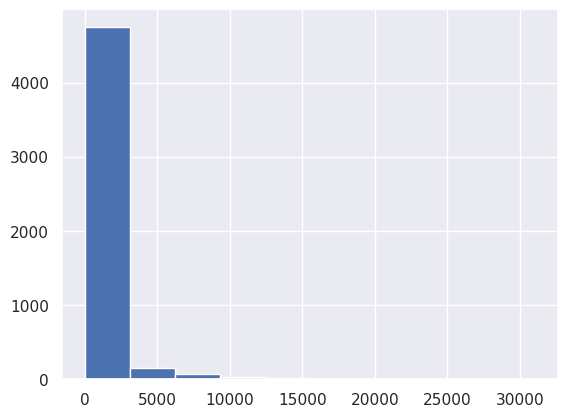

In [182]:
print(f"Histogram: {data['delay_in_seconds'].hist()}")

In [183]:
print(f"Skewness: {data['delay_in_seconds'].skew()}")

Skewness: 6.274560871857796


In [184]:
print(f"Kurtosis: {data['delay_in_seconds'].kurt()}")

Kurtosis: 63.136555037655754


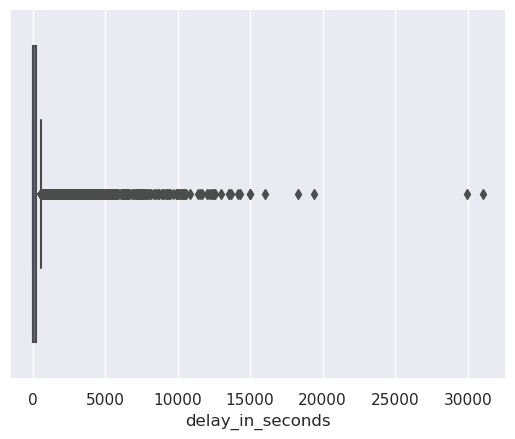

In [185]:
sns.boxplot(x = data['delay_in_seconds'])
plt.show()

### Atributo 'avg_temperature'

Ao contrário do anterior, este apenas tem um número pequeno de outliers (no upper bound), sendo a sua distribuição boa.

Histogram: AxesSubplot(0.125,0.11;0.775x0.77)


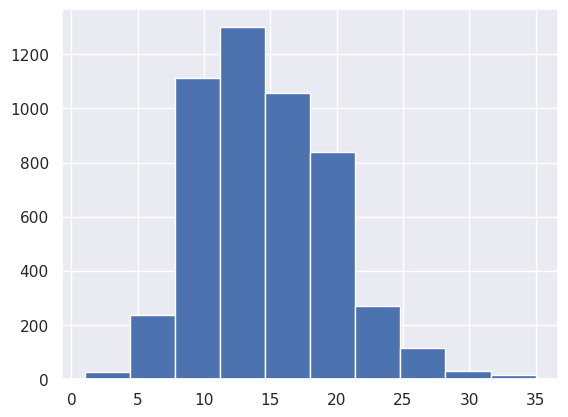

In [186]:
print(f"Histogram: {data['avg_temperature'].hist()}")

<AxesSubplot:xlabel='avg_temperature'>

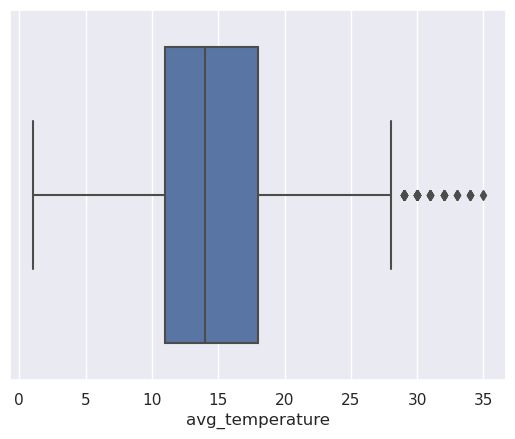

In [187]:
sns.boxplot(x = data['avg_temperature'])

In [188]:
print(f"Skewness: {data['avg_temperature'].skew()}")

Skewness: 0.5605064325594296


In [189]:
print(f"Kurtosis: {data['avg_temperature'].kurt()}")

Kurtosis: 0.5327725282841129


### Atributo 'avg_atm_pressure'

Análogo ao anterior, mas neste caso os outliers encontram-se no lower bound.

Histogram: AxesSubplot(0.125,0.11;0.775x0.77)


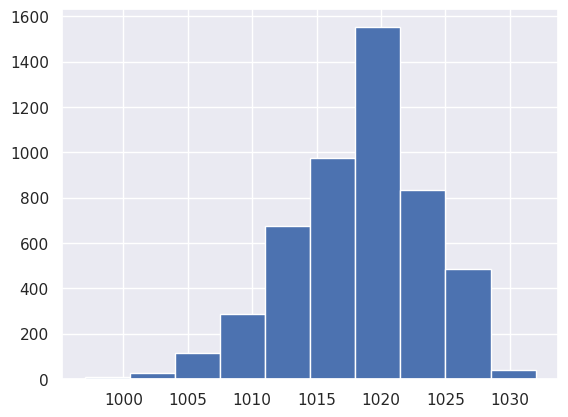

In [190]:
print(f"Histogram: {data['avg_atm_pressure'].hist()}")

<AxesSubplot:xlabel='avg_atm_pressure'>

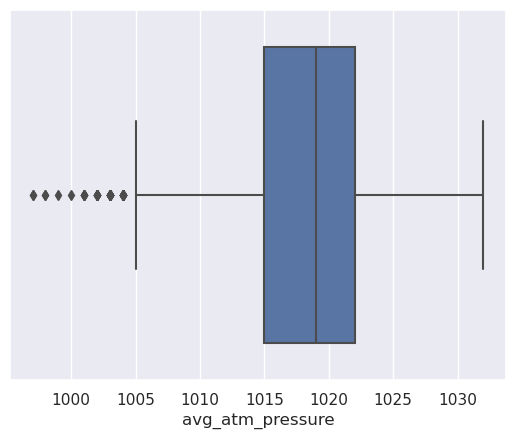

In [191]:
sns.boxplot(x = data['avg_atm_pressure'])

In [192]:
print(f"Skewness: {data['avg_atm_pressure'].skew()}")
print(f"Kurtosis: {data['avg_atm_pressure'].kurt()}")

Skewness: -0.40439693757842093
Kurtosis: 0.12068039465218394


### Atributo 'avg_humidity'

Análogo ao 'avg_atm_pressure'.

Histogram: AxesSubplot(0.125,0.11;0.775x0.77)


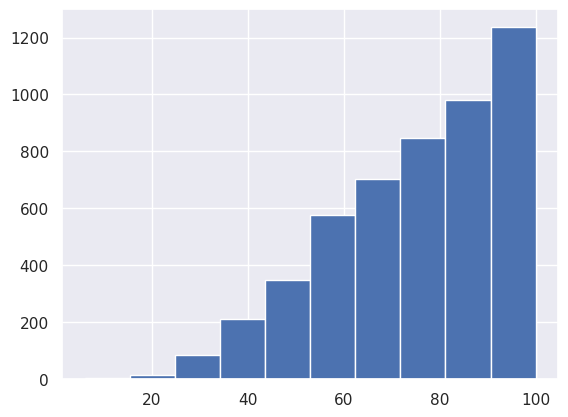

In [193]:
print(f"Histogram: {data['avg_humidity'].hist()}")

<AxesSubplot:xlabel='avg_humidity'>

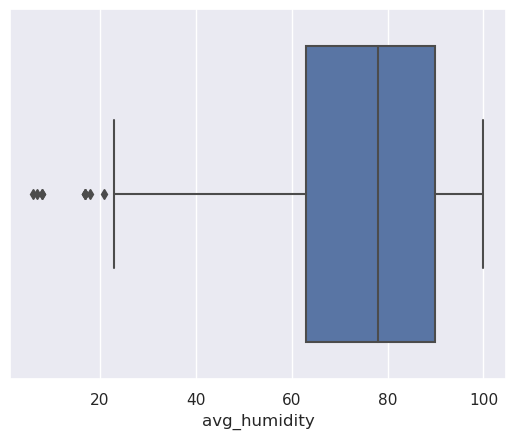

In [194]:
sns.boxplot(x = data['avg_humidity'])

In [195]:
print(f"Skewness: {data['avg_humidity'].skew()}")
print(f"Kurtosis: {data['avg_humidity'].kurt()}")

Skewness: -0.7626793660840018
Kurtosis: -0.2499175078373752


### Atributo 'avg_wind_speed'

Análogo ao 'avg_temerature'.

Histogram: AxesSubplot(0.125,0.11;0.775x0.77)


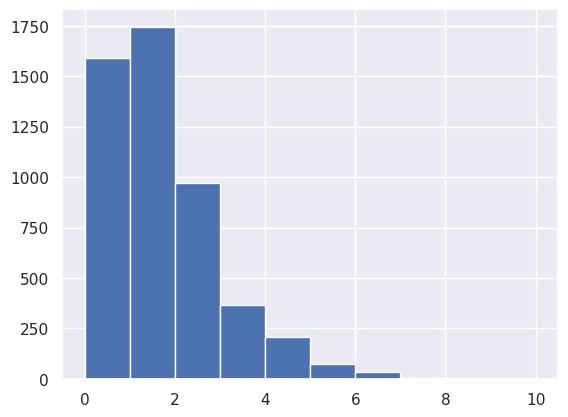

In [196]:
print(f"Histogram: {data['avg_wind_speed'].hist()}")

<AxesSubplot:xlabel='avg_wind_speed'>

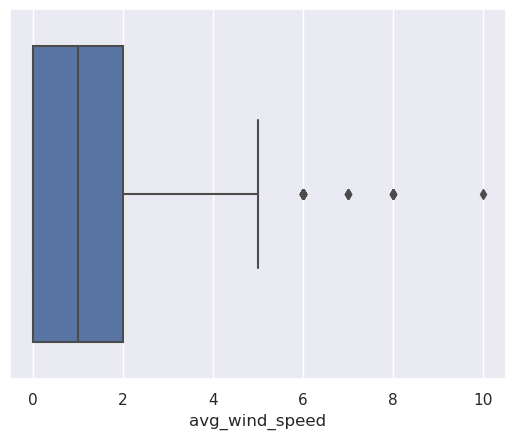

In [197]:
sns.boxplot(x = data['avg_wind_speed'])

In [198]:
print(f"Skewness: {data['avg_wind_speed'].skew()}")
print(f"Kurtosis: {data['avg_wind_speed'].kurt()}")

Skewness: 1.3610238434403679
Kurtosis: 2.5163102006982214


### Atributo 'avg_precipitation'

In [199]:
data['avg_precipitation'].value_counts()

0.0    5000
Name: avg_precipitation, dtype: int64

## Preparação de dados

Nomeadamente nos atributos numéricos que vão ser alterados, serão removidas algumas linhas.
Neste sentido, essas serão unicamente realizadas no dataset de treino.

### Remoção dos atributos 'avg_preciptation' e 'city_name'

- Removidos uma vez que são iguais para tds as linhas.

In [200]:
data.drop(['avg_precipitation', 'city_name'], axis = 1, inplace = True)
test.drop(['avg_precipitation', 'city_name'], axis = 1, inplace = True)

### Realizar Label Encoding no target ('incidents')

In [201]:
replace_map = {'incidents': {'None': 0, 'Low': 1, 'Medium': 2, 'High' : 3, 'Very_High':4}}

In [202]:
data.replace(replace_map, inplace = True)
test.replace(replace_map, inplace = True)
data.head()

,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents
0,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,Sem Chuva,0
1,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,Sem Chuva,0
2,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,Sem Chuva,1
3,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,Sem Chuva,4
4,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,Sem Chuva,3


### Realizar Label Encoding do atributo 'avg_rain'

In [203]:
data['avg_rain'].unique()

array(['Sem Chuva', 'chuva moderada', 'chuva fraca', 'chuva forte'],
      dtype=object)

In [204]:
replace_map_rain = {'avg_rain': {'Sem Chuva' : 0, 'chuva fraca' : 1, 'chuva moderada' : 2, 'chuva forte' : 3}}

In [205]:
data.replace(replace_map_rain, inplace = True)
test.replace(replace_map_rain, inplace = True)
data.head()

,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents
0,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0,0
1,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0,0
2,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0,1
3,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0,4
4,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0,3


### Realizar Label Encoding com o atributo 'luminosity'

In [206]:
data['luminosity'].unique()

array(['DARK', 'LIGHT', 'LOW_LIGHT'], dtype=object)

In [207]:
replace_map_luminosity = {'luminosity': {'LOW_LIGHT' : 1, 'LIGHT' : 2, 'DARK' : 0}}

In [208]:
data.replace(replace_map_luminosity, inplace = True)
test.replace(replace_map_luminosity, inplace = True)
data.head()

,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents
0,UNDEFINED,0,",",2021-03-15 23:00,0,12.0,1013.0,70.0,1.0,0,0
1,UNDEFINED,385,"N101,",2021-12-25 18:00,0,12.0,1007.0,91.0,1.0,0,0
2,UNDEFINED,69,",",2021-03-12 15:00,2,14.0,1025.0,64.0,0.0,0,1
3,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,2,15.0,1028.0,75.0,1.0,0,4
4,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,2,27.0,1020.0,52.0,1.0,0,3


### Substituir os "missing values" no atributo 'affected roads'

Não devemos remover linhas do dataset de teste, pelo que recrreu-se à subsituição.
Substituiu-se pela string "," -> simbólica da não existência de ruas afetadas.

In [209]:
values = {"affected_roads" : ","}
data = data.fillna(value=values)
test = test.fillna(value=values)

In [210]:
data.isna().sum()

magnitude_of_delay    0
delay_in_seconds      0
affected_roads        0
record_date           0
luminosity            0
avg_temperature       0
avg_atm_pressure      0
avg_humidity          0
avg_wind_speed        0
avg_rain              0
incidents             0
dtype: int64

In [211]:
test.isna().sum()

magnitude_of_delay    0
delay_in_seconds      0
affected_roads        0
record_date           0
luminosity            0
avg_temperature       0
avg_atm_pressure      0
avg_humidity          0
avg_wind_speed        0
avg_rain              0
dtype: int64

### Realizar One-Hot-Encoding no 'magnitude_of_delay'

- Contudo, isto resultou na criação de algumas linhas com valores null.

In [212]:
#one hot encoding
label = LabelBinarizer()
lb_results = label.fit_transform(data['magnitude_of_delay'])
lb_results_df = pd.DataFrame(lb_results, columns=label.classes_)
data = pd.concat([data, lb_results_df], axis=1)
data.drop(['magnitude_of_delay'], axis = 1, inplace = True)

lb_results = label.fit_transform(test['magnitude_of_delay'])
lb_results_df = pd.DataFrame(lb_results, columns=label.classes_)
test = pd.concat([test, lb_results_df], axis=1)
test.drop(['magnitude_of_delay'], axis = 1, inplace = True)


In [213]:
data

,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,MAJOR,MODERATE,UNDEFINED
0,0,",",2021-03-15 23:00,0,12.0,1013.0,70.0,1.0,0,0,0,0,1
1,385,"N101,",2021-12-25 18:00,0,12.0,1007.0,91.0,1.0,0,0,0,0,1
2,69,",",2021-03-12 15:00,2,14.0,1025.0,64.0,0.0,0,1,0,0,1
3,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,2,15.0,1028.0,75.0,1.0,0,4,1,0,0
4,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,2,27.0,1020.0,52.0,1.0,0,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,"N101,N101,N101,N101,N101,",2021-04-13 00:00,0,13.0,1021.0,56.0,0.0,0,3,0,0,1
4996,0,"N101,N101,N101,N101,N101",2021-07-06 14:00,2,19.0,1017.0,68.0,0.0,0,0,0,0,1
4997,0,",",2021-03-18 03:00,0,13.0,1023.0,47.0,2.0,0,0,0,0,1
4998,0,"N101,N101,N101,N101,N101",2021-11-02 06:00,0,12.0,1014.0,93.0,2.0,0,0,0,0,1


In [214]:
test

,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED
0,1211,"N101,N101,N101,N101,N101,N101,",2021-04-13 19:00,2,15.0,1018.0,80.0,0.0,0,0,0,1
1,0,"N101,N101,N101,N101,N101",2021-10-13 04:00,0,16.0,1018.0,41.0,2.0,0,0,0,1
2,0,"N101,N101,N101,N101,N101",2021-07-18 19:00,2,22.0,1017.0,71.0,0.0,0,0,0,1
3,140,"N101,R206,N101,N101,N101,N101",2021-10-30 15:00,2,18.0,1008.0,81.0,3.0,0,0,0,1
4,0,"N101,N101,N101,N101,N101",2021-10-18 10:00,2,20.0,1022.0,86.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1201,0,N101,2021-12-31 10:00,2,12.0,1025.0,70.0,2.0,0,0,0,1
1202,44,"N101,N101,N101,N101,N101",2021-07-16 00:00,0,24.0,1016.0,39.0,2.0,0,0,0,1
1203,1261,"N101,N101,N101,N101,N101,N101,N101",2021-12-19 15:00,2,13.0,1018.0,60.0,0.0,0,1,0,0
1204,246,",",2021-03-08 17:00,2,15.0,1015.0,50.0,1.0,0,0,0,1


### Atributo 'affected_roads'

- Inicialmente extraiu-se todas as ruas únicas das strings da coluna 'affected_roads'


Existem 4 tipos de estradas nos dois datasets, de teste e treino:
- Estradas nacionais (N)
- Estradas Municipais (EM)
- Itenerários Complementares (IC)
- Ruas (R)

Criou-se 5 novas colunas, com base nesta análise:
- Uma para cada tipo de estrada (N | EM | IC | R)
- o número de estradas únicas afetadas (n.estradas)

E realizou-se para as ruas uma estratégia de "one-hot-encoding",
colocando uma opção binária para caso as ruas afetadas são ou não
daquele tipo.

No final, apresentam-se 17 colunas no dataset.

In [215]:
all_roads = []

for row in data.index:
    roads = data['affected_roads'][row]

    roads_split = roads.split(',')
    for r in range(len(roads_split)):
        if(len(roads_split[r]) > 0):
            road = roads_split[r]
            all_roads.append(road)


all_roads = set(all_roads)

print("Todas as estradas unicas: ",all_roads)


Todas as estradas unicas:  {'IC5', 'EM579', 'N206', 'N207-4', 'N105', 'IC5 - N206', 'N310', 'N101', 'R206', 'N309'}


In [216]:
test_all_roads = []

for row in test.index:
    roads = test['affected_roads'][row]
    roads_split = roads.split(',')
    for r in range(len(roads_split)):
        if(len(roads_split[r]) > 0):
            road = roads_split[r]
            test_all_roads.append(road)


test_all_roads = set(test_all_roads)

print("Todas as estradas unicas: ",test_all_roads)

Todas as estradas unicas:  {'IC5', 'EM579', 'N206', 'N207-4', 'N105', 'N310', 'N101 - N310', 'N101', 'R206', 'N309'}


In [217]:
affected_ohe = []

for row in data.index:
    roads = data['affected_roads'][row]
    roads_split = roads.split(',')
    
    has_n = 0
    has_em = 0
    has_ic = 0
    has_r = 0
    n_roads = 0

    if 'N' in roads:
        has_n = 1

    if 'EM' in roads:
        has_em = 1 
    
    if 'IC' in roads:
        has_ic = 1

    if 'R' in roads:
        has_r = 1

    roads_list = []
    for road in roads_split:
        if road != "":
            roads_list.append(road)

    roads_set = set(roads_list)

    affected_ohe.append({
        'N': has_n, 
        'EM':has_em, 
        'IC':has_ic, 
        'R': has_r, 
        'n.estradas': len(roads_set)
    })

    affected_df = pd.DataFrame(affected_ohe)

affected_df

,N,EM,IC,R,n.estradas
0,0,0,0,0,0
1,1,0,0,0,1
2,0,0,0,0,0
3,1,0,0,1,3
4,1,0,0,0,1
...,...,...,...,...,...
4995,1,0,0,0,1
4996,1,0,0,0,1
4997,0,0,0,0,0
4998,1,0,0,0,1


In [218]:
data = pd.merge(data ,affected_df,left_index=True, right_index=True)
data.drop(['affected_roads'], axis = 1, inplace = True)
data

,delay_in_seconds,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas
0,0,2021-03-15 23:00,0,12.0,1013.0,70.0,1.0,0,0,0,0,1,0,0,0,0,0
1,385,2021-12-25 18:00,0,12.0,1007.0,91.0,1.0,0,0,0,0,1,1,0,0,0,1
2,69,2021-03-12 15:00,2,14.0,1025.0,64.0,0.0,0,1,0,0,1,0,0,0,0,0
3,2297,2021-09-29 09:00,2,15.0,1028.0,75.0,1.0,0,4,1,0,0,1,0,0,1,3
4,0,2021-06-13 11:00,2,27.0,1020.0,52.0,1.0,0,3,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,2021-04-13 00:00,0,13.0,1021.0,56.0,0.0,0,3,0,0,1,1,0,0,0,1
4996,0,2021-07-06 14:00,2,19.0,1017.0,68.0,0.0,0,0,0,0,1,1,0,0,0,1
4997,0,2021-03-18 03:00,0,13.0,1023.0,47.0,2.0,0,0,0,0,1,0,0,0,0,0
4998,0,2021-11-02 06:00,0,12.0,1014.0,93.0,2.0,0,0,0,0,1,1,0,0,0,1


In [219]:
affected_ohe = []

for row in test.index:
    roads = test['affected_roads'][row]
    roads_split = roads.split(',')
    
    has_n = 0
    has_em = 0
    has_ic = 0
    has_r = 0
    n_roads = 0

    if 'N' in roads:
        has_n = 1

    if 'EM' in roads:
        has_em = 1 
    
    if 'IC' in roads:
        has_ic = 1

    if 'R' in roads:
        has_r = 1

    roads_list = []
    for road in roads_split:
        if road != "":
            roads_list.append(road)

    roads_set = set(roads_list)

    affected_ohe.append({
        'N': has_n, 
        'EM':has_em, 
        'IC':has_ic, 
        'R': has_r, 
        'n.estradas': len(roads_set)
    })

    affected_df = pd.DataFrame(affected_ohe)

affected_df

,N,EM,IC,R,n.estradas
0,1,0,0,0,1
1,1,0,0,0,1
2,1,0,0,0,1
3,1,0,0,1,2
4,1,0,0,0,1
...,...,...,...,...,...
1201,1,0,0,0,1
1202,1,0,0,0,1
1203,1,0,0,0,1
1204,0,0,0,0,0


In [220]:
test = pd.merge(test ,affected_df,left_index=True, right_index=True)
test.drop(['affected_roads'], axis = 1, inplace = True)
test

,delay_in_seconds,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas
0,1211,2021-04-13 19:00,2,15.0,1018.0,80.0,0.0,0,0,0,1,1,0,0,0,1
1,0,2021-10-13 04:00,0,16.0,1018.0,41.0,2.0,0,0,0,1,1,0,0,0,1
2,0,2021-07-18 19:00,2,22.0,1017.0,71.0,0.0,0,0,0,1,1,0,0,0,1
3,140,2021-10-30 15:00,2,18.0,1008.0,81.0,3.0,0,0,0,1,1,0,0,1,2
4,0,2021-10-18 10:00,2,20.0,1022.0,86.0,0.0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,0,2021-12-31 10:00,2,12.0,1025.0,70.0,2.0,0,0,0,1,1,0,0,0,1
1202,44,2021-07-16 00:00,0,24.0,1016.0,39.0,2.0,0,0,0,1,1,0,0,0,1
1203,1261,2021-12-19 15:00,2,13.0,1018.0,60.0,0.0,0,1,0,0,1,0,0,0,1
1204,246,2021-03-08 17:00,2,15.0,1015.0,50.0,1.0,0,0,0,1,0,0,0,0,0


### Atributo 'record_date'

In [221]:
data_dt = data.copy()

In [222]:
data_dt['record_date'] = pd.to_datetime(data_dt['record_date'], format='%Y-%m-%d %H:%M', errors='coerce')

In [223]:
data_dt['record_date'].head()

0   2021-03-15 23:00:00
1   2021-12-25 18:00:00
2   2021-03-12 15:00:00
3   2021-09-29 09:00:00
4   2021-06-13 11:00:00
Name: record_date, dtype: datetime64[ns]

In [224]:
data['date_year'] = data_dt['record_date'].dt.year
data['date_month'] = data_dt['record_date'].dt.month
data['date_day'] = data_dt['record_date'].dt.day
data['date_hour'] = data_dt['record_date'].dt.hour
data.drop(['record_date'], axis=1, inplace = True)
test['date_year'] = data_dt['record_date'].dt.year
test['date_month'] = data_dt['record_date'].dt.month
test['date_day'] = data_dt['record_date'].dt.day
test['date_hour'] = data_dt['record_date'].dt.hour
test.drop(['record_date'], axis=1, inplace = True)
data.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_year,date_month,date_day,date_hour
0,0,0,12.0,1013.0,70.0,1.0,0,0,0,0,1,0,0,0,0,0,2021,3,15,23
1,385,0,12.0,1007.0,91.0,1.0,0,0,0,0,1,1,0,0,0,1,2021,12,25,18
2,69,2,14.0,1025.0,64.0,0.0,0,1,0,0,1,0,0,0,0,0,2021,3,12,15
3,2297,2,15.0,1028.0,75.0,1.0,0,4,1,0,0,1,0,0,1,3,2021,9,29,9
4,0,2,27.0,1020.0,52.0,1.0,0,3,0,0,1,1,0,0,0,1,2021,6,13,11


In [225]:
data['date_year'].unique()

array([2021])

In [226]:
data.drop(['date_year'], axis=1, inplace = True)
test.drop(['date_year'], axis=1, inplace = True)

In [227]:
data.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,0,0,12.0,1013.0,70.0,1.0,0,0,0,0,1,0,0,0,0,0,3,15,23
1,385,0,12.0,1007.0,91.0,1.0,0,0,0,0,1,1,0,0,0,1,12,25,18
2,69,2,14.0,1025.0,64.0,0.0,0,1,0,0,1,0,0,0,0,0,3,12,15
3,2297,2,15.0,1028.0,75.0,1.0,0,4,1,0,0,1,0,0,1,3,9,29,9
4,0,2,27.0,1020.0,52.0,1.0,0,3,0,0,1,1,0,0,0,1,6,13,11


In [228]:
test.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,1211,2,15.0,1018.0,80.0,0.0,0,0,0,1,1,0,0,0,1,3,15,23
1,0,0,16.0,1018.0,41.0,2.0,0,0,0,1,1,0,0,0,1,12,25,18
2,0,2,22.0,1017.0,71.0,0.0,0,0,0,1,1,0,0,0,1,3,12,15
3,140,2,18.0,1008.0,81.0,3.0,0,0,0,1,1,0,0,1,2,9,29,9
4,0,2,20.0,1022.0,86.0,0.0,0,0,0,1,1,0,0,0,1,6,13,11


## Atributos numéricos a manipular

Este capítulo foi criado baseados ns boxplots e histogramas visualizados na exploração dos dados, dos atributos numéricos.

Para este cas o grupo definiu que, se o número de outliers for inferior e/ou igual a 5%, procedia-se à sua remoção.
Caso contrário, realiza-se a tranformação dos dados.

### Atributo 'delay_in_seconds'

Os outliers no upper bound coorespondem a 17% dos dados.
Por este motivo, escolheu-se a transformação com log (Log Transformation) uma vez que o atributo tem valores muito enviesados.
Neste caso, os valores vão ser aproximados ao normal; dentro das possibilidades.

In [229]:
# Obter os valores do upper/lower bound do atributo
Q1 = data['delay_in_seconds'].quantile(q=0.25)
Q3 = data['delay_in_seconds'].quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)

lowerLim_delay = Q1 - 1.5 * IQR
upperLim_delay = Q3 + 1.5 * IQR

print(lowerLim_delay)
print(upperLim_delay)

234.0
-351.0
585.0


In [230]:
# Obter o número de valores no upper/lower bound
print("Antes do lower bound: ",data[data['delay_in_seconds'] < lowerLim_delay]['delay_in_seconds'].count())
print("Depois do upper bound: ",data[data['delay_in_seconds'] > upperLim_delay]['delay_in_seconds'].count())

Antes do lower bound:  0
Depois do upper bound:  884


In [231]:
data['delay_in_seconds'].mask(data['delay_in_seconds'] > upperLim_delay, upperLim_delay, inplace=True)

<AxesSubplot:xlabel='delay_in_seconds'>

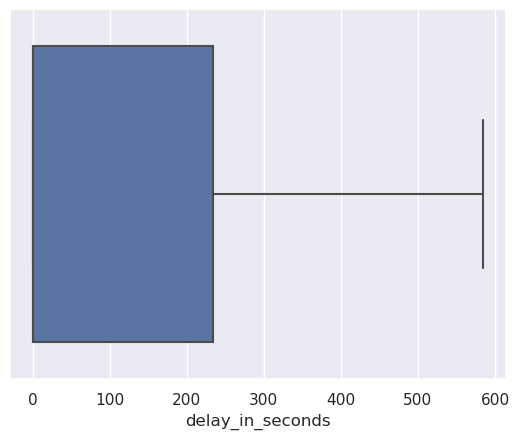

In [232]:
sns.boxplot(x = data['delay_in_seconds'])

#### Será realizada também a normalização do atributo em ambos datasets

In [233]:
scaler = MinMaxScaler(feature_range=(-1,1))
data['delay_in_seconds'] = scaler.fit_transform(data[['delay_in_seconds']])
test['delay_in_seconds'] = scaler.fit_transform(test[['delay_in_seconds']])

### Atributo 'avg_temperature'

Os outliers são no upper bound, e correspondem a 0.85% dos dados.
Pelo que estes serão removidos.

In [234]:
# Obter os valores do upper/lower bound do atributo
Q1 = data['avg_temperature'].quantile(q=0.25)
Q3 = data['avg_temperature'].quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)

lowerLim_temp = Q1 - 1.5 * IQR
upperLim_temp = Q3 + 1.5 * IQR

print(lowerLim_temp)
print(upperLim_temp)

7.0
0.5
28.5


In [235]:
# Obter o número de valores no upper/lower bound
print("Antes do lower bound: ",data[data['avg_temperature'] < lowerLim_temp]['avg_temperature'].count())
print("Depois do upper bound: ",data[data['avg_temperature'] > upperLim_temp]['avg_temperature'].count())

Antes do lower bound:  0
Depois do upper bound:  43


In [236]:
data.drop(data[(data['avg_temperature'] > upperLim_temp)].index, inplace=True)
data.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='avg_temperature'>

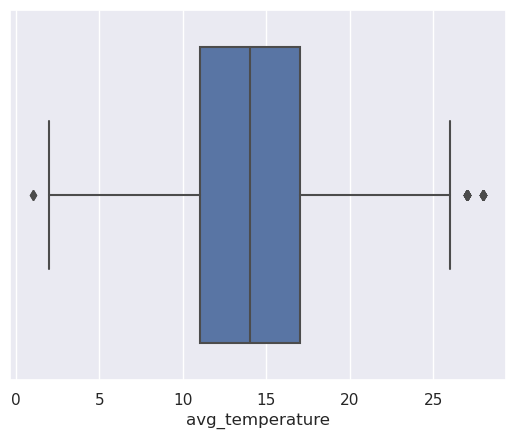

In [237]:
sns.boxplot(x = data['avg_temperature'])

### Normalização do atributo

In [238]:
scaler = MinMaxScaler(feature_range=(0,1))
data['avg_temperature'] = scaler.fit_transform(data[['avg_temperature']])
test['avg_temperature'] = scaler.fit_transform(test[['avg_temperature']])

### Atributo 'avg_atm_pressure'

Os outliers encontram-se no upperbound e correspondem a aproximadamente 0.87% dos dados.
Serão removidos.

In [239]:
# Obter os valores do upper/lower bound do atributo
Q1 = data['avg_atm_pressure'].quantile(q=0.25)
Q3 = data['avg_atm_pressure'].quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)

lowerLim = Q1 - 1.5 * IQR
upperLim = Q3 + 1.5 * IQR

print(lowerLim)
print(upperLim)

7.0
1004.5
1032.5


In [240]:
# Obter o número de valores no upper/lower bound
print("Antes do lower bound: ",data[data['avg_atm_pressure'] < lowerLim]['avg_atm_pressure'].count())
print("Depois do upper bound: ",data[data['avg_atm_pressure'] > upperLim]['avg_atm_pressure'].count())

Antes do lower bound:  45
Depois do upper bound:  0


In [241]:
data.drop(data[(data['avg_atm_pressure'] < lowerLim)].index, inplace=True)
data.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='avg_atm_pressure'>

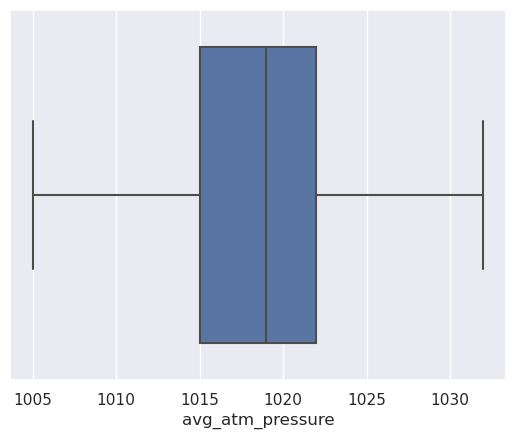

In [242]:
sns.boxplot(x = data['avg_atm_pressure'])

### Normalização do atributo

In [243]:
scaler = MinMaxScaler(feature_range=(0,1))
data['avg_atm_pressure'] = scaler.fit_transform(data[['avg_atm_pressure']])
test['avg_atm_pressure'] = scaler.fit_transform(test[['avg_atm_pressure']])

### Atributo 'avg_humidity'

In [244]:
# Obter os valores do upper/lower bound do atributo
Q1 = data['avg_humidity'].quantile(q=0.25)
Q3 = data['avg_humidity'].quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)

lowerLim = Q1 - 1.5 * IQR
upperLim = Q3 + 1.5 * IQR

print(lowerLim)
print(upperLim)

27.0
22.5
130.5


In [245]:
# Obter o número de valores no upper/lower bound
print("Antes do lower bound: ",data[data['avg_humidity'] < lowerLim]['avg_humidity'].count())
print("Depois do upper bound: ",data[data['avg_humidity'] > upperLim]['avg_humidity'].count())

Antes do lower bound:  7
Depois do upper bound:  0


In [246]:
data.drop(data[(data['avg_humidity'] < lowerLim)].index, inplace=True)
data.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='avg_humidity'>

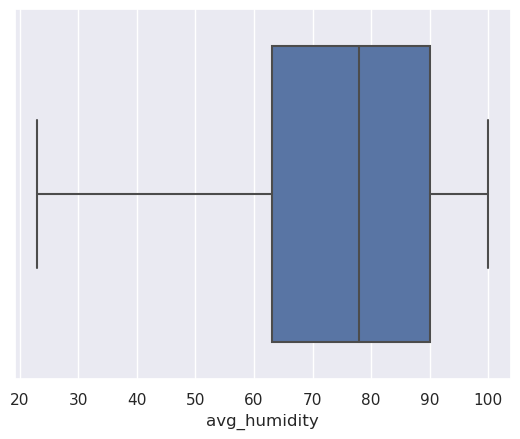

In [247]:
sns.boxplot(x = data['avg_humidity'])

### Normalização dos dados

In [248]:
scaler = MinMaxScaler(feature_range=(0,1))
data['avg_humidity'] = scaler.fit_transform(data[['avg_humidity']])
test['avg_humidity'] = scaler.fit_transform(test[['avg_humidity']])

### Atributo 'avg_wind_speed'

In [249]:
# Obter os valores do upper/lower bound do atributo
Q1 = data['avg_wind_speed'].quantile(q=0.25)
Q3 = data['avg_wind_speed'].quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)

lowerLim = Q1 - 1.5 * IQR
upperLim = Q3 + 1.5 * IQR

print(lowerLim)
print(upperLim)

2.0
-3.0
5.0


In [250]:
# Obter o número de valores no upper/lower bound
print("Antes do lower bound: ",data[data['avg_wind_speed'] < lowerLim]['avg_wind_speed'].count())
print("Depois do upper bound: ",data[data['avg_wind_speed'] > upperLim]['avg_wind_speed'].count())

Antes do lower bound:  0
Depois do upper bound:  42


In [251]:
data.drop(data[(data['avg_wind_speed'] > upperLim )].index, inplace=True)
data.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='avg_wind_speed'>

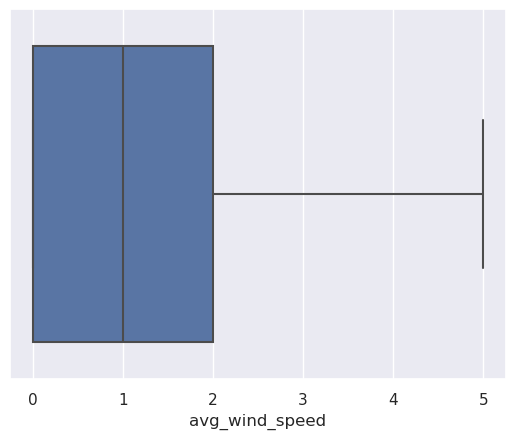

In [252]:
sns.boxplot(x = data['avg_wind_speed'])

### Normalização do atributo

In [253]:
scaler = MinMaxScaler(feature_range=(-1,1))
data['avg_wind_speed'] = scaler.fit_transform(data[['avg_wind_speed']])
test['avg_wind_speed'] = scaler.fit_transform(test[['avg_wind_speed']])

### Matriz de Correlação

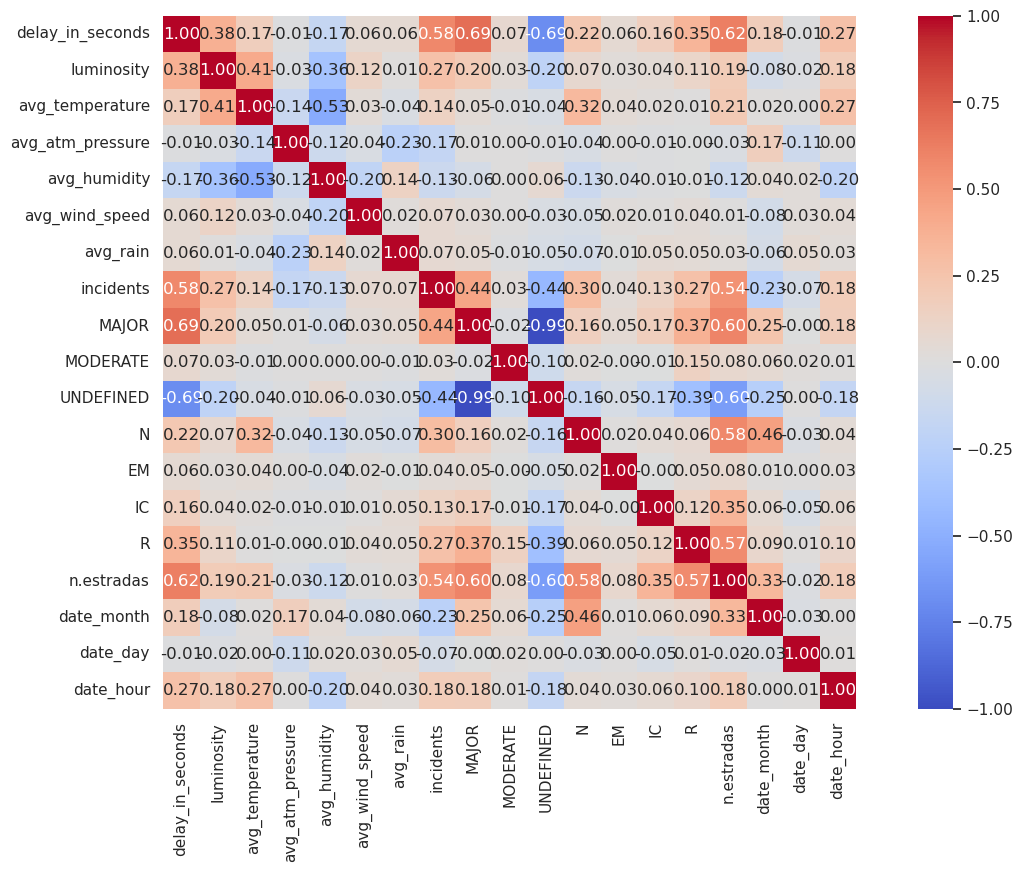

In [254]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True, fmt='.2f', cmap='coolwarm');

In [255]:
# sns.pairplot(data, hue='incidents', palette='Set1')

# Train Test Split

** Split your data into a training set and a testing set.**

In [256]:
data

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,-1.000000,0,0.407407,0.296296,0.610390,-0.6,0,0,0,0,1,0,0,0,0,0,3,15,23
1,0.316239,0,0.407407,0.074074,0.883117,-0.6,0,0,0,0,1,1,0,0,0,1,12,25,18
2,-0.764103,2,0.481481,0.740741,0.532468,-1.0,0,1,0,0,1,0,0,0,0,0,3,12,15
3,1.000000,2,0.518519,0.851852,0.675325,-0.6,0,4,1,0,0,1,0,0,1,3,9,29,9
4,-1.000000,2,0.962963,0.555556,0.376623,-0.6,0,3,0,0,1,1,0,0,0,1,6,13,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4858,-1.000000,0,0.444444,0.592593,0.428571,-1.0,0,3,0,0,1,1,0,0,0,1,4,13,0
4859,-1.000000,2,0.666667,0.444444,0.584416,-1.0,0,0,0,0,1,1,0,0,0,1,7,6,14
4860,-1.000000,0,0.444444,0.666667,0.311688,-0.2,0,0,0,0,1,0,0,0,0,0,3,18,3
4861,-1.000000,0,0.407407,0.333333,0.909091,-0.2,0,0,0,0,1,1,0,0,0,1,11,2,6


In [257]:
test

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,-0.837078,2,0.464286,0.59375,0.784946,-1.000000,0,0,0,1,1,0,0,0,1,3,15,23
1,-1.000000,0,0.500000,0.59375,0.365591,-0.555556,0,0,0,1,1,0,0,0,1,12,25,18
2,-1.000000,2,0.714286,0.56250,0.688172,-1.000000,0,0,0,1,1,0,0,0,1,3,12,15
3,-0.981165,2,0.571429,0.28125,0.795699,-0.333333,0,0,0,1,1,0,0,1,2,9,29,9
4,-1.000000,2,0.642857,0.71875,0.849462,-1.000000,0,0,0,1,1,0,0,0,1,6,13,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,-1.000000,2,0.357143,0.81250,0.677419,-0.555556,0,0,0,1,1,0,0,0,1,7,27,11
1202,-0.994080,0,0.785714,0.53125,0.344086,-0.555556,0,0,0,1,1,0,0,0,1,4,13,13
1203,-0.830351,2,0.392857,0.59375,0.569892,-1.000000,0,1,0,0,1,0,0,0,1,3,5,1
1204,-0.966904,2,0.464286,0.50000,0.462366,-0.777778,0,0,0,1,0,0,0,0,0,7,4,12


In [323]:
X = data.drop('incidents', axis=1)
Y = data['incidents'].to_frame()

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=2022, stratify=Y)

## Decision Tree

In [325]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [326]:
#Create an instance of a Decision Tree classifier
#Again, defining the random_state for reproducibility
clf = DecisionTreeClassifier(random_state=2022)

In [335]:
#to csv
X_train = data.drop(['incidents'], axis=1)
y_train = data['incidents'].to_frame()
X_test = test

In [336]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2022)

In [337]:
predictions = clf.predict(X_test)
predictions

array([1, 0, 3, ..., 2, 0, 3])

In [338]:
predictions = pd.DataFrame(predictions)
predictions.columns = ['Incidents']
predictions.index += 1
replace_map = {'Incidents' : {0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'}}
predictions.replace(replace_map, inplace = True)
predictions.to_csv('predictions.csv', index = True, index_label = 'RowId')

predictions

,Incidents
1,Low
2,None
3,High
4,Low
5,High
...,...
1202,None
1203,High
1204,Medium
1205,None


In [329]:
confusion_matrix(y_test, predictions)

array([[387,   8,   1,   2,   0],
       [ 13, 110,  11,   4,   0],
       [  1,   6,  93,  11,   2],
       [  0,   4,   6, 187,  11],
       [  1,   3,   5,  22,  85]])

In [330]:
accuracy_score(y_test, predictions)

0.8859198355601233

In [331]:
precision_score(y_test, predictions, average='macro')

0.8597771857355715

In [332]:
recall_score(y_test, predictions, average='macro')

0.8448538380212455

In [333]:
f1_score(y_test, predictions, average='macro')

0.8507429231690061

In [334]:
fbeta_score(y_test, predictions, beta=0.5, average='macro')

0.8557511900887154

## SVM

In [270]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score

In [271]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3890 entries, 1085 to 1904
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   delay_in_seconds  3890 non-null   float64
 1   luminosity        3890 non-null   int64  
 2   avg_temperature   3890 non-null   float64
 3   avg_atm_pressure  3890 non-null   float64
 4   avg_humidity      3890 non-null   float64
 5   avg_wind_speed    3890 non-null   float64
 6   avg_rain          3890 non-null   int64  
 7   MAJOR             3890 non-null   int64  
 8   MODERATE          3890 non-null   int64  
 9   UNDEFINED         3890 non-null   int64  
 10  N                 3890 non-null   int64  
 11  EM                3890 non-null   int64  
 12  IC                3890 non-null   int64  
 13  R                 3890 non-null   int64  
 14  n.estradas        3890 non-null   int64  
 15  date_month        3890 non-null   int64  
 16  date_day          3890 non-null   int64

In [272]:
cross_valid_model = SVC(random_state=2021)
scores = cross_val_score(cross_valid_model, X_train, np.ravel(y_train), cv=10)
scores

array([0.63496144, 0.59640103, 0.62467866, 0.6503856 , 0.62210797,
       0.66580977, 0.62210797, 0.63496144, 0.61182519, 0.63239075])

In [273]:
print("%0.2f accuracy" % (scores.mean()))

0.63 accuracy


In [274]:
model = SVC(random_state=2021)
model.fit(X_train, np.ravel(y_train))

SVC(random_state=2021)

In [275]:
print("%0.2f accuracy" % accuracy_score(y_test, predictions))

0.89 accuracy


/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


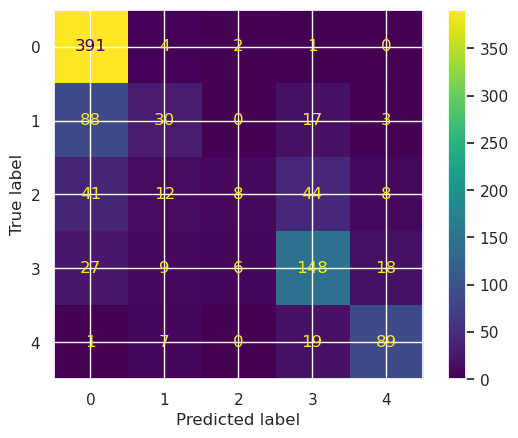

In [276]:
plot_confusion_matrix(model, X_test, y_test)

In [277]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       398
           1       0.84      0.80      0.82       138
           2       0.80      0.82      0.81       113
           3       0.83      0.90      0.86       208
           4       0.87      0.73      0.79       116

    accuracy                           0.89       973
   macro avg       0.86      0.84      0.85       973
weighted avg       0.89      0.89      0.88       973



In [278]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}

In [279]:
from sklearn.model_selection import GridSearchCV

In [280]:
grid = GridSearchCV(SVC(random_state=2021), param_grid, refit=True, verbose=3, n_jobs=-1)

In [281]:
grid.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.496 total time=   2.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.505 total time=   2.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.501 total time=   2.6s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.407 total time=   3.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.409 total time=   3.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.407 total time=   4.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.486 total time=   2.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.494 total time=   2.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.409 total time=   4.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.506 total time=   3.6s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.409 total time=   1.8s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf

GridSearchCV(estimator=SVC(random_state=2021), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [282]:
grid.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [283]:
grid.best_estimator_

SVC(C=1000, gamma=0.01, random_state=2021)

In [849]:
#to csv
predictions = grid.predict(X_test)
predictions = pd.DataFrame(predictions)
predictions.columns = ['Incidents']
predictions.index += 1
replace_map = {'Incidents' : {0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'}}
predictions.replace(replace_map, inplace = True)
predictions.to_csv('predictions.csv', index = True, index_label = 'RowId')

/home/josefam/miniconda3/envs/daa/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


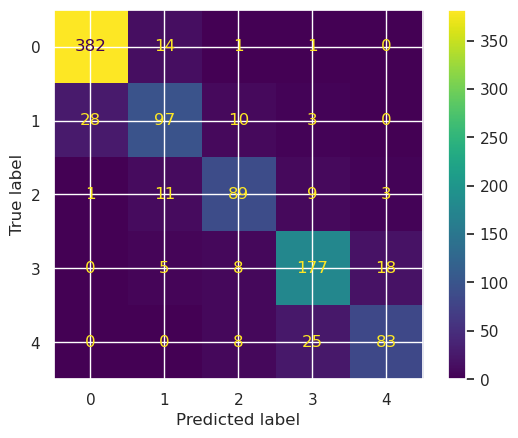

In [284]:
plot_confusion_matrix(grid, X_test, y_test)

In [285]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       398
           1       0.76      0.70      0.73       138
           2       0.77      0.79      0.78       113
           3       0.82      0.85      0.84       208
           4       0.80      0.72      0.75       116

    accuracy                           0.85       973
   macro avg       0.82      0.80      0.81       973
weighted avg       0.85      0.85      0.85       973



## Neural

Build our neural network 

In [316]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler


In [317]:
#Scale the data
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(Y)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)
Y_scaled = pd.DataFrame(scaler_y.transform(Y[Y.columns]), columns=Y.columns)

In [318]:
X.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,-1.000000,0,0.407407,0.296296,0.610390,-0.6,0,0,0,1,0,0,0,0,0,3,15,23
1,0.316239,0,0.407407,0.074074,0.883117,-0.6,0,0,0,1,1,0,0,0,1,12,25,18
2,-0.764103,2,0.481481,0.740741,0.532468,-1.0,0,0,0,1,0,0,0,0,0,3,12,15
3,1.000000,2,0.518519,0.851852,0.675325,-0.6,0,1,0,0,1,0,0,1,3,9,29,9
4,-1.000000,2,0.962963,0.555556,0.376623,-0.6,0,0,0,1,1,0,0,0,1,6,13,11


In [319]:
X_scaled.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,0.000000,0.0,0.407407,0.307692,0.610390,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.181818,0.466667,1.000000
1,0.658120,0.0,0.407407,0.076923,0.883117,0.2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.125,1.000000,0.800000,0.782609
2,0.117949,1.0,0.481481,0.769231,0.532468,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.181818,0.366667,0.652174
3,1.000000,1.0,0.518519,0.884615,0.675325,0.2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.375,0.727273,0.933333,0.391304
4,0.000000,1.0,0.962963,0.576923,0.376623,0.2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.125,0.454545,0.400000,0.478261


In [309]:
Y.head()

,incidents
0,0
1,0
2,1
3,4
4,3


In [320]:
Y_scaled.head()

,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,MAJOR,MODERATE,UNDEFINED,N,EM,IC,R,n.estradas,date_month,date_day,date_hour
0,0.081461,1.0,0.464286,0.59375,0.784946,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.142857,0.181818,0.466667,1.000000
1,0.000000,0.0,0.500000,0.59375,0.365591,0.222222,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.142857,1.000000,0.800000,0.782609
2,0.000000,1.0,0.714286,0.56250,0.688172,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.142857,0.181818,0.366667,0.652174
3,0.009417,1.0,0.571429,0.28125,0.795699,0.333333,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.285714,0.727273,0.933333,0.391304
4,0.000000,1.0,0.642857,0.71875,0.849462,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.142857,0.454545,0.400000,0.478261


In [310]:
# to generate the csv
X = data.drop('incidents', axis=1)
Y = test

scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X[X.columns]), columns=X.columns)

scaler_Y = MinMaxScaler(feature_range=(0, 1)).fit(Y)
Y_scaled = pd.DataFrame(scaler_Y.transform(Y[Y.columns]), columns=Y.columns)

X_train = X_scaled
y_train = data[['incidents']]

X_test = Y_scaled


In [322]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.20, random_state=2022, stratify=Y)

ValueError: Found input variables with inconsistent numbers of samples: [4863, 1206]

In [293]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3890, 18) (3890, 1) (973, 18) (973, 1)


In [311]:
def build_model(activation='relu', learning_rate=0.01):
    model = Sequential()
    #model.add(Dense(20, input_dim=10, activation=activation))
    model.add(Dense(36, input_dim=18, activation='relu'))
    model.add(Dense(18, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        metrics=['accuracy']
    )
    return model

In [312]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 36)                684       
_________________________________________________________________
dense_19 (Dense)             (None, 18)                666       
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 95        
Total params: 1,445
Trainable params: 1,445
Non-trainable params: 0
_________________________________________________________________


In [313]:
TUNING_DICT = {
    #'activation': ['relu', 'tanh'],
    'learning_rate' : [0.01,0.001],
    'batch_size' : [32],
    'epochs' : [40]
}

In [314]:
kf = KFold(n_splits=10, shuffle=True, random_state=2022)

model = KerasClassifier(build_model, activation='relu', learning_rate=0.01)
grid_search = GridSearchCV(estimator = model,
                           param_grid = TUNING_DICT,
                           cv = kf,
                           scoring = 'accuracy',
                           verbose = 3,
                           n_jobs = -1)

grid_search.fit(X_train, y_train, validation_split=0.3)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Train on 3063 samples, validate on 1314 samples
Train on 3063 samples, validate on 1314 samples
Train on 3063 samples, validate on 1314 samples
Train on 3063 samples, validate on 1313 samples
Train on 3063 samples, validate on 1314 samples
Train on 3063 samples, validate on 1313 samples
Train on 3063 samples, validate on 1314 samples
Train on 3063 samples, validate on 1313 samples
Train on 3063 samples, validate on 1313 samples
Train on 3063 samples, validate on 1314 samples
Train on 3063 samples, validate on 1314 samples
Train on 3063 samples, validate on 1313 samples
Epoch 1/40
Epoch 1/40
Epoch 1/40
 192/3063 [>.............................] - ETA: 8s - loss: 1.4938 - acc: 0.3750 Epoch 1/40
Epoch 1/40[========>.....................] - ETA: 1s - loss: 1.3464 - acc: 0.452
3063/3063 [==============================] - 2s 568us/sample - loss: 1.0703 - acc: 0.5818 - val_loss: 0.8272 - val_acc: 0.7002
Epoch 2/40
1344/3063 [=======

KeyboardInterrupt: 

In [ ]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
accuracy = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']
for accuracy, param in zip(accuracy, params):
    print("%f with: %r" % (accuracy, param))


Best: 0.805141 using {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.01}
0.805141 with: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.01}
0.763239 with: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.001}


In [ ]:
best_mlp_model = grid_search.best_estimator_

In [ ]:
predictions = best_mlp_model.predict(X_test)
predictions = pd.DataFrame(predictions)
predictions.columns = ['Incidents']
predictions.index += 1
replace_map = {'Incidents' : {0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'}}
predictions.replace(replace_map, inplace = True)
predictions.to_csv('predictions.csv', index = True, index_label = 'RowId')

In [ ]:
from livelossplot import PlotLossesKerasTF

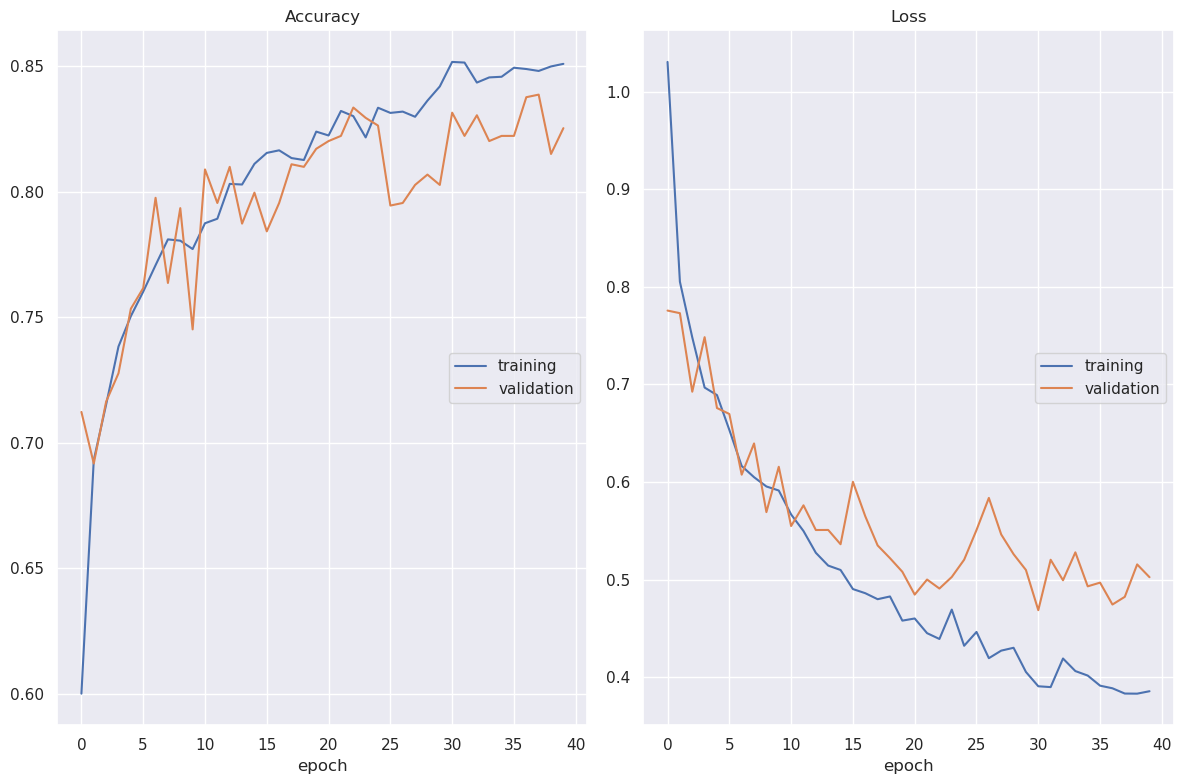

Accuracy
	training         	 (min:    0.600, max:    0.852, cur:    0.851)
	validation       	 (min:    0.692, max:    0.839, cur:    0.825)
Loss
	training         	 (min:    0.383, max:    1.031, cur:    0.386)
	validation       	 (min:    0.469, max:    0.776, cur:    0.502)
3890/3890 [==============================] - 1s 253us/sample - loss: 0.3856 - acc: 0.8509 - val_loss: 0.5024 - val_acc: 0.8253


In [ ]:
#print the validation accuracy and loss after each epoch
plot_losses = PlotLossesKerasTF()

best_mlp_model.fit(X_train, y_train, 
                   validation_data=(X_test, y_test),
                   callbacks=[PlotLossesKerasTF()], verbose=1)

In [300]:
predictions = best_mlp_model.predict(X_test)

In [301]:
accuracy_score(y_test, predictions)

0.8252826310380267